In [1]:
# Подгрузить библиотеки.

import pandas as pd
import numpy as np
from numpy import sin, cos, arccos, pi, round
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn. model_selection import train_test_split
from sklearn. linear_model import LogisticRegression
from sklearn import metrics

In [2]:
# Изучить данные. Отобразить общую информацию по признакам. Описать свои наблюдения.

df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-gabdulhanova/Test_task_Gabdulkhanova/dataset_taxi.xls')
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [3]:
df.dtypes

offer_gk                    int64
weekday_key                 int64
hour_key                    int64
driver_gk                   int64
order_gk                    int64
driver_latitude           float64
driver_longitude          float64
origin_order_latitude     float64
origin_order_longitude    float64
distance_km               float64
duration_min              float64
offer_class_group          object
ride_type_desc             object
driver_response             int64
dtype: object

### Описание данных
- offer_gk: Уникальный ID предложения заказа водителю.  
- weekday_key: Номер дня недели (начинается с 0, далее 1 и т.д. Так как по широте и долготе адреса российские, предположу, что начало недели - Понедельник).  
- hour_key: Час в сутках, в течение которого было сделано предложение водителю (от 0 до 23).  
- driver_gk: Уникальный ID водителя.  
- order_gk: Уникальный ID исходной заявки пассажира. Судя по сравнению количества заявок и предложений водителям - по одной заявке может быть сделано несколько предложений разным водителям. 
- driver_latitude: Координаты нахождения водителя на момент предложения (широта)  
- driver_longitude:  Координаты нахождения водителя на момент предложения (долгота)  
- origin_order_latitude: Координаты нахождения пассажира на момент предложения (широта)  
- origin_order_longitude: Координаты нахождения пассажира на момент предложения (долгота)  
- distance_km: Предполагаемая дистанция поездки в км. В записях встречается значение -1, которое идёт в паре с таким же значением поля 'duration_min'. Можно предположить, что для таких заказов невозможно рассчитать предполагаемую дистанцию и время поездки, т.е. такси вызвано без обозначения конечной точки.  
- duration_min: Предполагаемое время поездки в мин (-1 означает, что конечная точка не назначена)  
- offer_class_group: Класс заказа. Значения: 'Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Test' (*нужно будет удалить*), 'Premium', 'VIP', 'VIP+'.  
- ride_type_desc: Тип заказа. Значения: 'private', 'business', 'affiliate', 'SMB'.  
- driver_response: Решение водителя о принятии заказа. Значения: 0 - заказ не принят, 1 - заказ принят. 

Уникальные значения и их количество проверялись через методы unique(), nunique().

### Предварительный анализ

Необходимо построить модель для предсказания ответа водителя на предложение заказа - согласится он его взять или нет.  
Какие признаки можно учесть в анализе:  
- Время заказа: 'weekday_key', 'hour_key'
- Расстояние водителя от пассажира: можно рассчитать на основе 'driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'
- Предполагаемая длительность и время поездки: 'distance_km', 'duration_min'. Так как есть записи с неизвестной конечной точкой поездки, эти группы данных можно попробовать анализировать отдельно.
- Категориальные характеристики заявки: 'offer_class_group', 'ride_type_desc'. Для анализа нужно будет преобразовать.  
  
Идентификаторы водителя, заказа и поездки вряд ли будут значимы.

In [4]:
# Выявить пропуски, а также возможные причины их возникновения. Решить, что следует сделать с ними. 
# Описать свои наблюдения и решение.

### Исследование данных
Проверим данные на наличие пропусков и аномальные значения.

In [5]:
# Проверка на наличие NaN - таких значений в данных не нашлось.

df.isna().sum()

offer_gk                  0
weekday_key               0
hour_key                  0
driver_gk                 0
order_gk                  0
driver_latitude           0
driver_longitude          0
origin_order_latitude     0
origin_order_longitude    0
distance_km               0
duration_min              0
offer_class_group         0
ride_type_desc            0
driver_response           0
dtype: int64

In [6]:
# Затем метод describe() для отслеживания аномалий (предварительно убрав столбцы с идентификаторами как неинформативные).

df = df.drop(columns=['offer_gk', 'driver_gk', 'order_gk'])
df.describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.159860,13.827790,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,2.054222,7.306496,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,5.000000,20.000000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


Видим, что отсутствующие значения (-1) есть не только в столбцах, для которых это ожидаемо:  
- distance_km
- duration_min  

Но и в данных по местонахождению пассажира и водителя:
- driver_latitude
- driver_longitude
- origin_order_latitude
- origin_order_longitude

Исследуем записи с отсутствующими координатами.

In [7]:
# Сначала посчитаем.

df[df['driver_latitude'] == -1].shape, df[df['driver_longitude'] == -1].shape

((140, 11), (140, 11))

In [8]:
# Количество одинаковое. 
# Выясним - в одинаковых ли записях отсутствуют и долгота, и широта.

driver_latitude_index = df[df['driver_latitude'] == -1].index
driver_longitude_index = df[df['driver_longitude'] == -1].index

False in (driver_latitude_index == driver_longitude_index)

False

Выяснили, что у данных по местоположению водителя в записях, где нет информации, её нет по обоим признакам - и по широте, и по долготе.  
Аналогично проверим по местоположению пассажира.


In [9]:
# Считаем

df[df['origin_order_latitude'] == -1].shape, df[df['origin_order_longitude'] == -1].shape

((13, 11), (13, 11))

In [10]:
# Количество тоже одинаковое, хотя и значительно меньше, чем у водителей. 
# Выясним - в одинаковых ли записях отсутствуют и долгота, и широта.

origin_latitude_index = df[df['origin_order_latitude'] == -1].index
origin_longitude_index = df[df['origin_order_longitude'] == -1].index

False in (origin_latitude_index == origin_longitude_index)

False

Количество записей с пропусками информации по координатам небольшое, поэтому можно очистить от них весь набор данных.

In [11]:
df = df.drop(index=[*origin_latitude_index, *driver_latitude_index])

In [12]:
df.describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000,99847.000000
mean,3.160055,13.826635,55.780324,37.546255,55.780191,37.546314,18.412009,23.159354,0.491752
std,2.054491,7.308412,0.234164,0.196938,0.156110,0.159890,41.150741,33.901250,0.499934
min,0.000000,0.000000,0.000000,0.000000,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709284,37.413497,55.708502,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773079,37.533872,55.772731,37.532191,10.442000,19.750000,0.000000
75%,5.000000,20.000000,55.960696,37.624235,55.962035,37.624145,30.695000,37.883000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


У водителя видим нулевое значение в координатах, исследуем аналогично.

In [13]:
df[df['driver_latitude'] == 0].shape, df[df['driver_longitude'] == 0].shape

((1, 11), (1, 11))

In [14]:
# Количество записей совпадает. Проверяем, одна и та же эта запись или нет.

driver_empty_latitude_index = df[df['driver_latitude'] == 0].index
driver_empty_longitude_index = df[df['driver_longitude'] == 0].index

driver_empty_latitude_index == driver_empty_longitude_index

array([ True])

In [15]:
# Да, запись одна. Можно от неё избавиться.

df = df.drop(index=driver_empty_latitude_index)
df.describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000
mean,3.160087,13.826633,55.780883,37.546631,55.780195,37.546311,18.411756,23.159030,0.491757
std,2.054477,7.308449,0.153851,0.157053,0.156106,0.159887,41.150869,33.901266,0.499935
min,0.000000,0.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709285,37.413497,55.708502,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773085,37.533874,55.772734,37.532189,10.441500,19.750000,0.000000
75%,5.000000,20.000000,55.960697,37.624235,55.962035,37.624145,30.694750,37.883000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


Рассматриваем аналогично поездки. Например, есть очень длинные и долгие.  
Посмотрим, сколько их - учитывая среднее и медиану, возьмем за границу, например, 150 км.

In [16]:
df[df['distance_km'] > 150].shape

(78, 11)

In [17]:
# В контексте всего количества записей это немного, можно избавиться.

long_distance_index = df[df['distance_km'] > 150].index
df = df.drop(index=long_distance_index)
df.describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99768.000000,99768.000000,99768.000000,99768.000000,99768.000000,99768.000000,99768.000000,99768.000000,99768.000000
mean,3.159771,13.826137,55.780960,37.546563,55.780273,37.546242,17.770461,22.678656,0.491621
std,2.054533,7.309043,0.153807,0.157000,0.156061,0.159830,20.252737,20.744817,0.499932
min,0.000000,0.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709313,37.413497,55.708583,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773146,37.533839,55.772758,37.532104,10.418000,19.717000,0.000000
75%,5.000000,20.000000,55.960729,37.624173,55.962043,37.623995,30.611000,37.833000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,149.809000,139.500000,1.000000


Можно еще проверить, нет ли пустых (нулевых) поездок по длительности и дистанции, т.е. поездка вряд ли состоялась.

In [18]:
df[df['distance_km'] == 0].shape, df[df['duration_min'] == 0].shape

((152, 11), (152, 11))

In [19]:
# Смотрим, совпадают ли у этих записей индексы.

empty_distance_index = df[df['distance_km'] == 0].index
empty_duration_index = df[df['duration_min'] == 0].index

False in (empty_distance_index == empty_duration_index)

False

In [20]:
# Это одни и те же записи. Их не слишком много, можно убрать.

df = df.drop(index=empty_distance_index)
df.describe()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,99616.000000,99616.000000,99616.000000,99616.000000,99616.000000,99616.000000,99616.000000,99616.000000,99616.000000
mean,3.159884,13.828562,55.780969,37.546515,55.780282,37.546196,17.797576,22.713261,0.491628
std,2.054433,7.307989,0.153810,0.156982,0.156063,0.159809,20.256274,20.741700,0.499932
min,0.000000,0.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,55.709319,37.413497,55.708587,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,55.773158,37.533812,55.772768,37.532104,10.459500,19.767000,0.000000
75%,5.000000,20.000000,55.960729,37.624125,55.962046,37.623950,30.666000,37.867000,1.000000
max,6.000000,23.000000,56.174097,38.280547,56.172361,38.243608,149.809000,139.500000,1.000000


Исследуем заказы, где не была указана финальная точка поездки, следовательно, нельзя посчитать прогнозируемую дистанцию и время.

In [21]:
df[df['distance_km'] == -1].shape, df[df['duration_min'] == -1].shape

((26083, 11), (26083, 11))

In [22]:
# Количество одинаковое и достаточно большое. Проверим на всякий случай совпадение этих признаков в записях по индексам.

unknown_distance_index = df[df['distance_km'] == -1].index
unknown_duration_index = df[df['duration_min'] == -1].index

False in (unknown_distance_index == unknown_duration_index)

False

Записей с неизвестными расстоянием поездки и длительностью много, они совпадают по индексам. Возможно, нужно анализировать отдельно.

### Преобразование данных

Для корректного определения зависимостей нужно преобразовать данные:
- рассчитать на основе координат расстояние от водителя до пассажира в момент заказа
- преобразовать категориальные признаки для использования в моделях

In [23]:
# Нашла набор функций для расчета расстояния между географическими координатами. 
# Geopy установить на учебный инструмент не могу, поэтому попыталась найти более ручное решение. 

def rad2deg(radians):
    degrees = radians * 180 / pi
    return degrees

def deg2rad(degrees):
    radians = degrees * pi / 180
    return radians

def getDistanceBetweenPointsNew(latitude1, longitude1, latitude2, longitude2, unit = 'miles'):
    
    theta = longitude1 - longitude2
    
    distance = 60 * 1.1515 * rad2deg(
        arccos(
            (sin(deg2rad(latitude1)) * sin(deg2rad(latitude2))) + 
            (cos(deg2rad(latitude1)) * cos(deg2rad(latitude2)) * cos(deg2rad(theta)))
        )
    )
    
    if unit == 'miles':
        return round(distance, 2)
    if unit == 'kilometers':
        return round(distance * 1.609344, 2)

In [24]:
# Добавили новый столбец с расчётом расстояния между водителем и пассажиром

df['driver_order_distance'] = getDistanceBetweenPointsNew(df['driver_latitude'], df['driver_longitude'], df['origin_order_latitude'], df['origin_order_longitude'], unit = 'kilometers')
df.head()

,weekday_key,hour_key,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,driver_order_distance
0,5,20,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,1.36
1,5,14,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,3.41
2,6,14,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0.41
3,2,6,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,0.65
4,4,16,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1.06


In [25]:
# Возможно, разумно будет удалить информацию о координатах, на основе которой мы посчитали расстояние.

df = df.drop(columns=['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'])
df.head()

,weekday_key,hour_key,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,driver_order_distance
0,5,20,-1.000,-1.000,Economy,private,0,1.36
1,5,14,18.802,25.217,Standard,private,1,3.41
2,6,14,6.747,9.800,Economy,private,0,0.41
3,2,6,-1.000,-1.000,Economy,private,1,0.65
4,4,16,12.383,19.250,Economy,private,1,1.06


In [26]:
# В колонке "offer_class_group" в самом начале мы находили значение "Test", возможно, нужно от него избавиться.

df['offer_class_group'].unique()

array(['Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Test', 'Premium',
       'VIP', 'VIP+'], dtype=object)

In [27]:
# Посмотрим, сколько там записей.

df_test = df[df['offer_class_group'] == 'Test']
df_test.shape

(8, 8)

In [28]:
# Совсем немного, можно убрать.

df = df.query('offer_class_group != "Test"')

In [29]:
df = pd.get_dummies(df, drop_first = True)

df.columns

Index(['weekday_key', 'hour_key', 'distance_km', 'duration_min',
       'driver_response', 'driver_order_distance', 'offer_class_group_Economy',
       'offer_class_group_Kids', 'offer_class_group_Premium',
       'offer_class_group_Standard', 'offer_class_group_VIP',
       'offer_class_group_VIP+', 'offer_class_group_XL',
       'ride_type_desc_affiliate', 'ride_type_desc_business',
       'ride_type_desc_private'],
      dtype='object')

### Зависимость переменных между собой

Разделим для анализа все данные на 2 части, в зависимости от наличия информации о конечной точке.

In [30]:
df_with_final = df[df['distance_km'] != -1]
df_without_final = df[df['distance_km'] == -1]

df_without_final = df_without_final.drop(columns=['distance_km', 'duration_min'])

In [31]:
df_with_final.shape, df_without_final.shape

((73533, 16), (26075, 14))

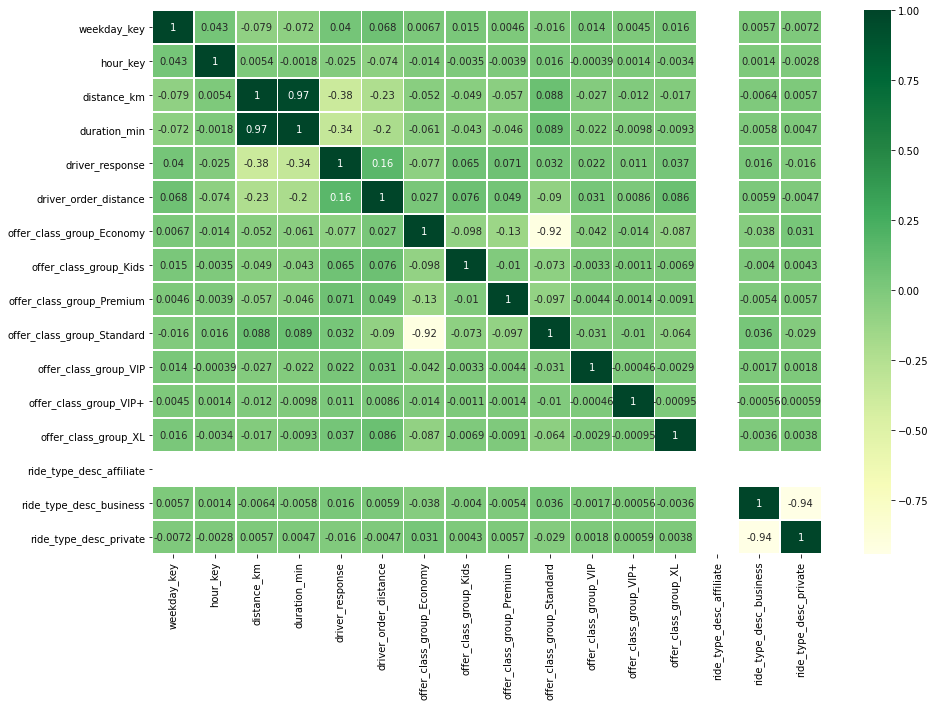

In [32]:
# Можно посмотреть корреляцию переменных между собой.

plt.figure(figsize=(15, 10))

sns.heatmap(df_with_final.corr(method='spearman'), annot=True, linewidths=0.5, cmap='YlGn')
plt.show()

Кажется, можно усмотреть небольшую отрицательную корреляцию между ответом водителя и расстоянием и временем предполагаемой поездки.  
Также есть логичная корреляция между расстоянием поездки и её длительностью - создаёт мультиколлинеарность, лучше убрать один из признаков; между классами заказа; между типами заказа.

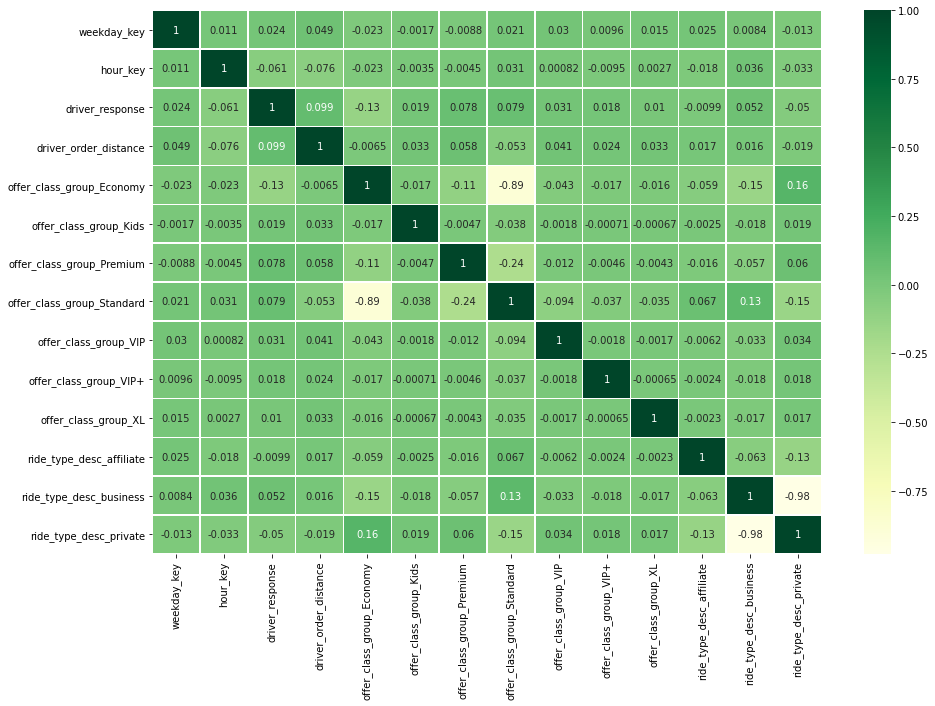

In [33]:
# В данных без информации о конечной точке поездки остальные корреляции, кажется, аналогичны.

plt.figure(figsize=(15, 10))

sns.heatmap(df_without_final.corr(method='spearman'), annot=True, linewidths=0.5, cmap='YlGn')
plt.show()

### Модели с известной финальной точкой поездки

Посмотрим на результат модели с учетом всех признаков (кроме duration_min, он сильно коррелирует с distance_km, можно оставить только его).

In [34]:
X = df_with_final[['weekday_key', 'hour_key', 'distance_km', 'driver_order_distance', 'offer_class_group_Economy',
       'offer_class_group_Kids', 'offer_class_group_Premium',
       'offer_class_group_Standard', 'offer_class_group_VIP',
       'offer_class_group_VIP+', 'offer_class_group_XL',
       'ride_type_desc_affiliate', 'ride_type_desc_business',
       'ride_type_desc_private']]
Y = df_with_final['driver_response']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0) 

In [35]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(X_train, Y_train)
predicted_y = classifier.predict(X_test)
print('Accuracy: {:.5f}'.format(classifier.score(X_test, Y_test)))

Accuracy: 0.67838


Рассмотрим только расчетное расстояние поездки и расстояние от водителя до заказа.

In [36]:
X_2 = df_with_final[['distance_km', 'driver_order_distance']]
Y_2 = df_with_final['driver_response']

X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, test_size=0.3, random_state=0) 

In [37]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(X_2_train, Y_2_train)
predicted_y = classifier.predict(X_2_test)
print('Accuracy: {:.5f}'.format(classifier.score(X_2_test, Y_2_test)))

Accuracy: 0.67611


Результат почти такой же, как при анализе полного списка характеристик.  
Влияет ли класс заказа?

In [38]:
X_3 = df_with_final[['offer_class_group_Economy',
       'offer_class_group_Kids', 'offer_class_group_Premium',
       'offer_class_group_Standard', 'offer_class_group_VIP',
       'offer_class_group_VIP+', 'offer_class_group_XL']]
Y_3 = df_with_final['driver_response']

X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(X_3, Y_3, test_size=0.3, random_state=0) 

In [39]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(X_3_train, Y_3_train)
predicted_y = classifier.predict(X_3_test)
print('Accuracy: {:.5f}'.format(classifier.score(X_3_test, Y_3_test)))

Accuracy: 0.54986


Влияет ли тип поездки?

In [40]:
X_4 = df_with_final[['ride_type_desc_affiliate', 'ride_type_desc_business',
       'ride_type_desc_private']]
Y_4 = df_with_final['driver_response']

X_4_train, X_4_test, Y_4_train, Y_4_test = train_test_split(X_4, Y_4, test_size=0.3, random_state=0) 

In [41]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(X_4_train, Y_4_train)
predicted_y = classifier.predict(X_4_test)
print('Accuracy: {:.5f}'.format(classifier.score(X_4_test, Y_4_test)))

Accuracy: 0.53005


Если же оставить только расчетное расстояние поездки, оно присутствует в проанализированных наборах с лучшими пока результатами.

In [42]:
X_5 = df_with_final[['distance_km']]
Y_5 = df_with_final['driver_response']

X_5_train, X_5_test, Y_5_train, Y_5_test = train_test_split(X_5, Y_5, test_size=0.3, random_state=0) 

In [43]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(X_5_train, Y_5_train)
predicted_y = classifier.predict(X_5_test)
print('Accuracy: {:.5f}'.format(classifier.score(X_5_test, Y_5_test)))

Accuracy: 0.67366


### Вывод
Лучший результат - около 68% - получается при анализе всего набора данных. Практически равны ему по точности результаты моделей, который используют расчетное расстояние поездки и расстояние от водителя до заказа, причем расчетное расстояние поездки в одиночку может дать похожий результат.

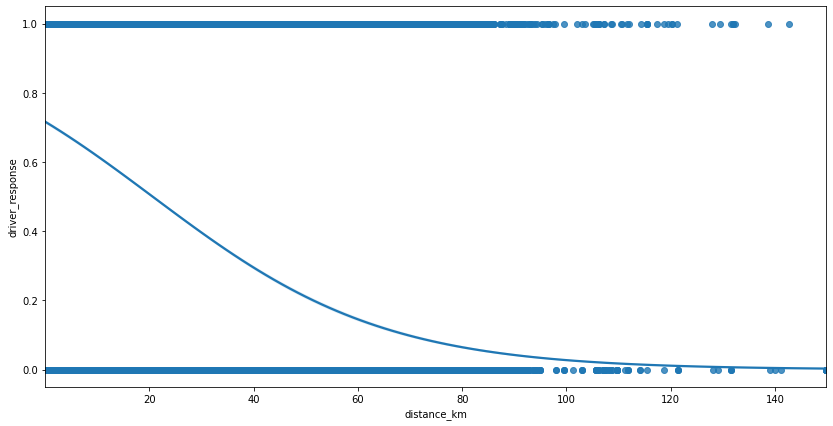

In [44]:
# Визуализация

f, ax = plt.subplots(figsize=(14, 7))

sns.regplot(x=df_with_final['distance_km'],
            y=df_with_final['driver_response'],
            logistic=True);

### Модели с неизвестной финальной точкой поездки

In [45]:
A = df_without_final[['weekday_key', 'hour_key', 'driver_order_distance',
       'offer_class_group_Economy', 'offer_class_group_Kids',
       'offer_class_group_Premium', 'offer_class_group_Standard',
       'offer_class_group_VIP', 'offer_class_group_VIP+',
       'offer_class_group_XL', 'ride_type_desc_affiliate',
       'ride_type_desc_business', 'ride_type_desc_private']]
B = df_without_final['driver_response']

A_train, A_test, B_train, B_test = train_test_split(A, B, test_size=0.3, random_state=0) 

In [46]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(A_train, B_train)
predicted_y = classifier.predict(A_test)
print('Accuracy: {:.5f}'.format(classifier.score(A_test, B_test)))

Accuracy: 0.57753


In [47]:
A_2 = df_without_final[['driver_order_distance']]
B_2 = df_without_final['driver_response']

A_2_train, A_2_test, B_2_train, B_2_test = train_test_split(A_2, B_2, test_size=0.3, random_state=0) 

In [48]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(A_2_train, B_2_train)
predicted_y = classifier.predict(A_2_test)
print('Accuracy: {:.8f}'.format(classifier.score(A_2_test, B_2_test)))

Accuracy: 0.54787166


In [49]:
A_3 = df_without_final[['offer_class_group_Economy', 'offer_class_group_Kids',
       'offer_class_group_Premium', 'offer_class_group_Standard',
       'offer_class_group_VIP', 'offer_class_group_VIP+',
       'offer_class_group_XL']]
B_3 = df_without_final['driver_response']

A_3_train, A_3_test, B_3_train, B_3_test = train_test_split(A_3, B_3, test_size=0.3, random_state=0) 

In [50]:
classifier = LogisticRegression(solver='liblinear',random_state=0)
classifier.fit(A_3_train, B_3_train)
predicted_y = classifier.predict(A_3_test)
print('Accuracy: {:.8f}'.format(classifier.score(A_3_test, B_3_test)))

Accuracy: 0.57803912


### Вывод
Лучший результат (но всё равно слабый) равен примерно 58% и получается при анализе класса предложения поездки. Это примерно равно результату на всём пакете данных.